COVID Data Science Tools

Data Science Tools 
Constructor University Bremen
By: Leonardo Corredor

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler # Estandarizador para PCA: centrar y escalar variables
from sklearn.decomposition import PCA # PCA para reducción de dimensionalidad

# Load data

DATA_DIR = Path("data")
WHO_FILE = DATA_DIR / "WHO-COVID-19.csv"
WDI_FILE = DATA_DIR / "WDI.csv"


who = pd.read_csv(WHO_FILE)
wdi = pd.read_csv(WDI_FILE)



In [2]:
# WHO ordering and cleaning
who["Date_reported"] = pd.to_datetime(who["Date_reported"], errors="coerce") # Converts Date column to datetime
who = who.dropna(subset=["Date_reported"]).sort_values(["Country", "Date_reported"]) # Drops rows with invalid dates and sorts by Country and Date_reported

who["New_cases"] = pd.to_numeric(who["New_cases"], errors="coerce").fillna(0) # Converting to numeric and filling NaNs with 0
who["New_deaths"] = pd.to_numeric(who["New_deaths"], errors="coerce").fillna(0) # Convergint to numeric and filling NaNs with 0

In [3]:
# Helper functions

def smooth_n(x: pd.Series, n: int) -> pd.Series: # Defines a function to compute trailing moving average 
    """
    Trailing moving average with 'lag defaults = 0' (similar spirit to the R hint).
    For n=3: (x + lag1 + lag2) / 3 with missing lags treated as 0.
    """
    x = x.astype(float)
    acc = x.copy()
    for k in range(1, n):
        acc = acc + x.shift(k, fill_value=0.0)
    return acc / n

def shiftscale(x: pd.Series, shift: int, scale: float) -> pd.Series: # Defines a function to shift and scale a time series
    """
    Shift by 'shift' days (lag in time) and scale magnitude by 'scale'.
    """
    return x.shift(shift, fill_value=0.0) * scale

In [4]:
# Transformations by country

g = who.groupby("Country", group_keys=False)

who["Cum_cases"]  = g["New_cases"].cumsum() #Cases by country
who["Cum_deaths"] = g["New_deaths"].cumsum() #Deaths by country

who["New_cases_smooth3"]  = g["New_cases"].apply(lambda s: smooth_n(s, 3)) # Applies smoothing function by country each 3,7,10 days
who["New_cases_smooth7"]  = g["New_cases"].apply(lambda s: smooth_n(s, 7))
who["New_cases_smooth10"] = g["New_cases"].apply(lambda s: smooth_n(s, 10))

who["New_deaths_smooth3"]  = g["New_deaths"].apply(lambda s: smooth_n(s, 3)) # Applies smoothing function by country each 3,7,10 days
who["New_deaths_smooth7"]  = g["New_deaths"].apply(lambda s: smooth_n(s, 7))
who["New_deaths_smooth10"] = g["New_deaths"].apply(lambda s: smooth_n(s, 10))

who["Diff_cases_smooth7"] = g["New_cases_smooth7"].diff().fillna(0.0) # Calculates derivative of smoothed cases and deaths


In [5]:
# WDI: rename long variables

WDI_RENAME = {
    "Urban population (% of total population)": "urban_pop",
    "Rural population (% of total population)": "rural_pop",
    "Proportion of people living below 50 percent of median income (%)": "pop_lower_half_median",
    "Population, total": "pop",
    "Population ages 65 and above (% of total population)": "pop_older65",
    "Population density (people per sq. km of land area)": "pop_density",
    "Physicians (per 1,000 people)": "physicians_per_1000",
    "Life expectancy at birth, total (years)": "life_expectancy",
    "GDP per capita, PPP (current international $)": "gdp_per_capita",
}
wdi = wdi.rename(columns=WDI_RENAME)

for col in WDI_RENAME.values():
    if col in wdi.columns:
        wdi[col] = pd.to_numeric(wdi[col], errors="coerce") #Converting to numeric

# Convenience lists
WDI_ID_COLS = ["country", "iso3c", "region"]
WDI_NUM_COLS = [c for c in wdi.columns if c not in WDI_ID_COLS]


1.1 Covid Cases and Deaths in Germany’s 1st wave

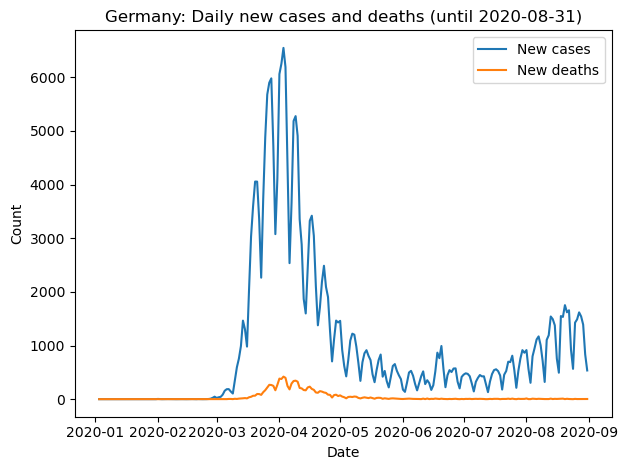

(Date_reported    2020-04-03 00:00:00
 New_cases                       6549
 Name: 78247, dtype: object,
 Date_reported    2020-04-03 00:00:00
 New_deaths                       420
 Name: 78247, dtype: object)

In [6]:
#Plot Germany new cases and deaths until August 31, 2020

end_date = pd.Timestamp("2020-08-31")
de = who[(who["Country"] == "Germany") & (who["Date_reported"] <= end_date)].copy()
de = de.sort_values("Date_reported")

plt.figure()
plt.plot(de["Date_reported"], de["New_cases"], label="New cases")
plt.plot(de["Date_reported"], de["New_deaths"], label="New deaths")
plt.title("Germany: Daily new cases and deaths (until 2020-08-31)")
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

# Peak values (for description)

peak_cases_row = de.loc[de["New_cases"].idxmax(), ["Date_reported", "New_cases"]]
peak_deaths_row = de.loc[de["New_deaths"].idxmax(), ["Date_reported", "New_deaths"]]

peak_cases_row, peak_deaths_row


-In Germany the first wave starts in late February and grows fast during March.

-Daily cases and daily deaths rise sharply and reach a clear peak in early April.

-From April to May, the numbers go down and become more stable.

-The highest daily number was 6549

-The highest daily number of deaths was 420.

1.2 Cumulative cases in Germany, Italy, France, and UK

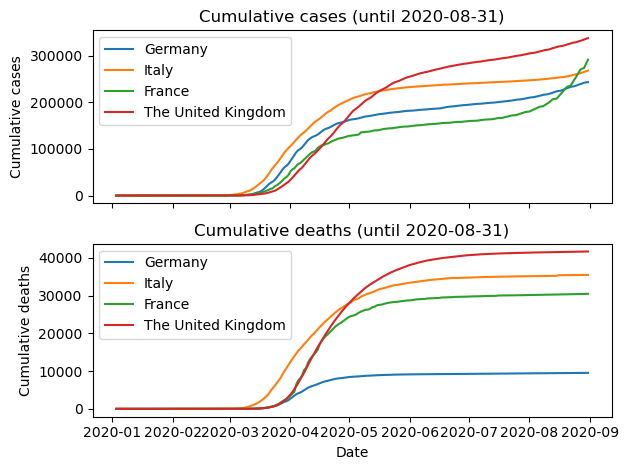

In [7]:
#Cumulative cases Germany, Italy, France, UK until August 31, 2020


countries = ["Germany", "Italy", "France", "The United Kingdom"]

d4 = who[
    (who["Country"].isin(countries)) &
    (who["Date_reported"] <= pd.Timestamp("2020-08-31"))
].copy()

d4 = d4.sort_values(["Country", "Date_reported"])

fig, axes = plt.subplots(2, 1, sharex=True)

for c in countries:
    sub = d4[d4["Country"] == c]
    axes[0].plot(sub["Date_reported"], sub["Cum_cases"], label=c)
    axes[1].plot(sub["Date_reported"], sub["Cum_deaths"], label=c)

axes[0].set_title("Cumulative cases (until 2020-08-31)")
axes[0].set_ylabel("Cumulative cases")
axes[0].legend()

axes[1].set_title("Cumulative deaths (until 2020-08-31)")
axes[1].set_ylabel("Cumulative deaths")
axes[1].set_xlabel("Date")
axes[1].legend()

plt.tight_layout()
plt.show()


-Cumulative curves show the “integral” of the daily time series.

-Differences between countries can come from timing of interventions, mobility patterns, testing strategies, and healthcare capacity.

1.3 Smoothing daily data

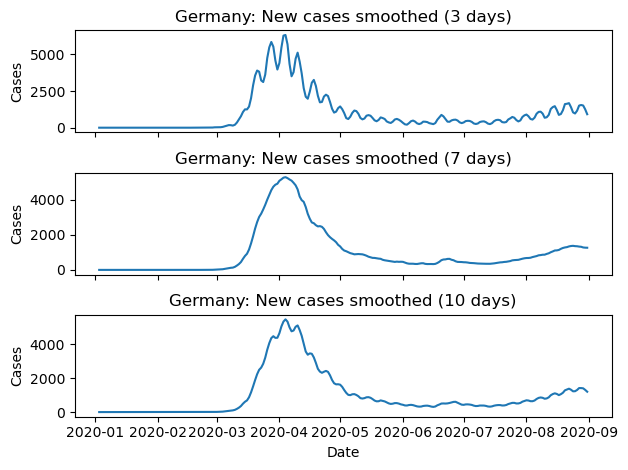

In [8]:
#Smoothing Germany new cases 3,7,10 days until August 31, 2020

de = who[(who["Country"] == "Germany") & (who["Date_reported"] <= pd.Timestamp("2020-08-31"))].copy()
de = de.sort_values("Date_reported")

fig, axes = plt.subplots(3, 1, sharex=True) # Ir creates 3 subplots sharing x-axis

# Ir plots smoothed new cases for Germany each 3, 7 and 10 days

axes[0].plot(de["Date_reported"], de["New_cases_smooth3"])
axes[0].set_title("Germany: New cases smoothed (3 days)")
axes[0].set_ylabel("Cases")

axes[1].plot(de["Date_reported"], de["New_cases_smooth7"])
axes[1].set_title("Germany: New cases smoothed (7 days)")
axes[1].set_ylabel("Cases")

axes[2].plot(de["Date_reported"], de["New_cases_smooth10"])
axes[2].set_title("Germany: New cases smoothed (10 days)")
axes[2].set_ylabel("Cases")
axes[2].set_xlabel("Date")

plt.tight_layout()
plt.show()


-Smoothing reduces day-to-day noise and helps us see the main trend. The longer selected time the smother.

1.4 How do deaths follow cases?

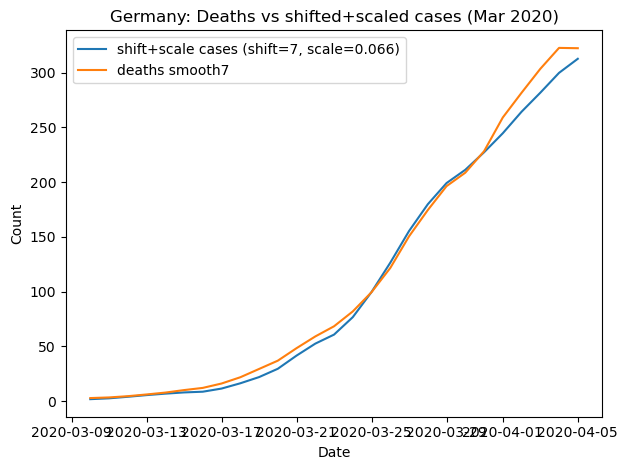

In [9]:
#Shifted and scaled cases vs deaths Germany March 2020

de_full = who[who["Country"] == "Germany"].copy()
de_full = de_full.sort_values("Date_reported")

# Start values:

SHIFT_DAYS = 7 #defining shift days
SCALE = 0.066 #defining scale factor

de_full["shiftscale_cases"] = shiftscale(de_full["New_cases_smooth7"], shift=SHIFT_DAYS, scale=SCALE) # creating new column with shifted and scaled cases

mask_march = (de_full["Date_reported"] >= "2020-03-10") & (de_full["Date_reported"] <= "2020-04-05") #extracting data from march and begining april
tmp = de_full.loc[mask_march].copy()

plt.figure()
plt.plot(tmp["Date_reported"], tmp["shiftscale_cases"], label=f"shift+scale cases (shift={SHIFT_DAYS}, scale={SCALE})")
plt.plot(tmp["Date_reported"], tmp["New_deaths_smooth7"], label="deaths smooth7")
plt.title("Germany: Deaths vs shifted+scaled cases (Mar 2020)")
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()


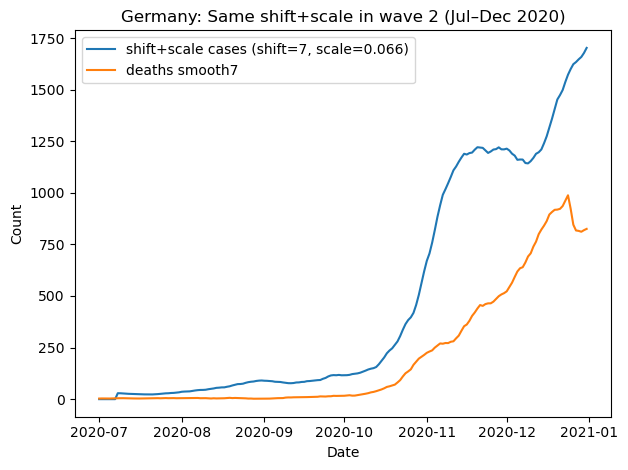

In [10]:
#Shift scale Germany wave 2 (July-Dec 2020)

mask_wave2 = (de_full["Date_reported"] >= "2020-07-01") & (de_full["Date_reported"] <= "2020-12-31") #defining time to work with
tmp2 = de_full.loc[mask_wave2].copy()
tmp2["shiftscale_cases"] = shiftscale(tmp2["New_cases_smooth7"], shift=SHIFT_DAYS, scale=SCALE)

plt.figure()
plt.plot(tmp2["Date_reported"], tmp2["shiftscale_cases"], label=f"shift+scale cases (shift={SHIFT_DAYS}, scale={SCALE})")
plt.plot(tmp2["Date_reported"], tmp2["New_deaths_smooth7"], label="deaths smooth7")
plt.title("Germany: Same shift+scale in wave 2 (Jul–Dec 2020)")
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()


-Deaths typically follow cases with a time delay because severe outcomes happen days after infection and diagnosis.

-In the first wave, a shift of around one week often gives a good overlap in the exponential growth phase.

-In wave 2, the overlap is usually weaker. The relation between cases and deaths can change because of age distribution, testing, treatment, and better protection of high-risk groups.

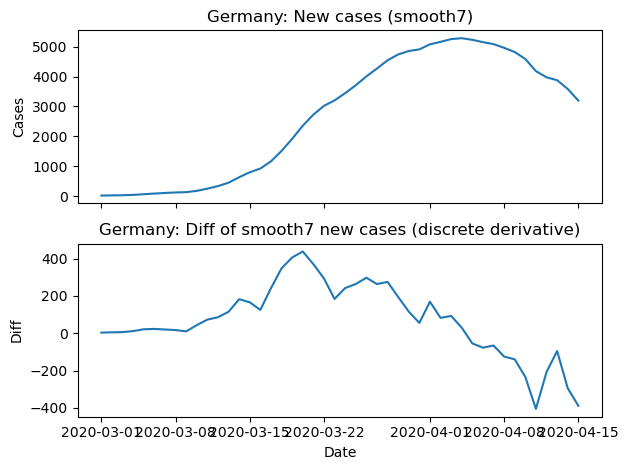

(Date_reported         2020-03-20 00:00:00
 Diff_cases_smooth7                  438.0
 Name: 78233, dtype: object,
 Date_reported        2020-04-04 00:00:00
 New_cases_smooth7            5282.142857
 Name: 78248, dtype: object)

In [11]:
#Wave Break for GErmany

de_break = who[(who["Country"] == "Germany") &
(who["Date_reported"] >= "2020-03-01") &
(who["Date_reported"] <= "2020-04-15")].copy()
de_break = de_break.sort_values("Date_reported")

fig, axes = plt.subplots(2, 1, sharex=True)

axes[0].plot(de_break["Date_reported"], de_break["New_cases_smooth7"])
axes[0].set_title("Germany: New cases (smooth7)")
axes[0].set_ylabel("Cases")

axes[1].plot(de_break["Date_reported"], de_break["Diff_cases_smooth7"])
axes[1].set_title("Germany: Diff of smooth7 new cases (discrete derivative)")
axes[1].set_ylabel("Diff")
axes[1].set_xlabel("Date")

plt.tight_layout()
plt.show()

peak_diff = de_break.loc[de_break["Diff_cases_smooth7"].idxmax(), ["Date_reported", "Diff_cases_smooth7"]]
peak_smooth = de_break.loc[de_break["New_cases_smooth7"].idxmax(), ["Date_reported", "New_cases_smooth7"]]

peak_diff, peak_smooth


-The diff series is the change in smoothed new cases from one day to the next.

-When the diff is positive, cases are still growing faster.
-When the diff goes down, the growth starts to slow.

-In Germany, the peak of the diff happens before the peak of smoothed cases. This shows that the first wave starts to break before the maximum number of cases is reached.

World Development Indicators

2.1 Correlation

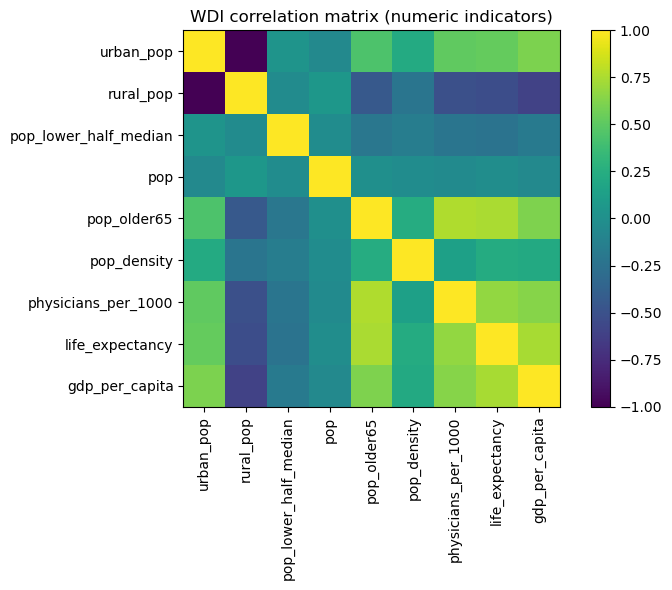

urban_pop            rural_pop             -1.000000
pop_older65          physicians_per_1000    0.761008
                     life_expectancy        0.743962
life_expectancy      gdp_per_capita         0.735709
physicians_per_1000  life_expectancy        0.679066
dtype: float64

In [12]:
#Correlation matrix WDI numeric indicators

wdi_num = wdi[WDI_NUM_COLS] #it selects only numeric columns
corr = wdi_num.corr(numeric_only=True) #calculates correlation matrix

plt.figure(figsize=(8, 6))
plt.imshow(corr.values)
plt.title("WDI correlation matrix (numeric indicators)")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.tight_layout()
plt.show()

# Top absolute correlations 

pairs = (
corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
.stack()
.sort_values(key=lambda s: s.abs(), ascending=False)
)
pairs.head(5)# Top absolute correlations


-Urban population and rural population have a very strong negative correlation. This is expected because they describe opposite parts of the population.

-Health and development variables are also strongly related. Countries with higher income often have higher life expectancy and better health system.

In [13]:
# Label wdi pca
# small one: removing all rows with any NA

wdi_noNA_small = wdi.dropna().copy()

# Large: dropoing 2 variables with most NA, then remove remaining NA rows

na_counts = wdi[WDI_NUM_COLS].isna().sum().sort_values(ascending=False)
drop_two = list(na_counts.index[:2])

wdi_large_base = wdi.drop(columns=drop_two)
WDI_NUM_COLS_LARGE = [c for c in wdi_large_base.columns if c not in WDI_ID_COLS]
wdi_noNA_large = wdi_large_base.dropna().copy()

n_total = wdi.shape[0]
n_small = wdi_noNA_small.shape[0] #number of rows without NA
n_large = wdi_noNA_large.shape[0] #number of rows without NA after dropping two columns

n_total, n_small, n_large, drop_two


(217, 162, 203, ['pop_lower_half_median', 'gdp_per_capita'])

In [14]:
#Missing big countries after filtering NA

def missing_big_countries( #defines function to find missing big countries
    original: pd.DataFrame,
    filtered: pd.DataFrame,
    threshold: int = 1_000_000
) -> pd.DataFrame:
    lost = original.merge( #filtring original dataframe with filtered one
        filtered[["iso3c"]],
        on="iso3c",
        how="left",
        indicator=True
    )
    lost = lost[lost["_merge"] == "left_only"].drop(columns=["_merge"])
    lost_big = lost[lost["pop"].fillna(0) > threshold].copy() #filtering big countries by population
    return (
        lost_big[["country", "iso3c", "region", "pop"]]
        .sort_values("pop", ascending=False) #it returns sorted dataframe
    )


lost_small = missing_big_countries(wdi, wdi_noNA_small) #list of lost big countries for small and large datasets

lost_large = missing_big_countries(wdi_large_base, wdi_noNA_large) #list of lost big countries for large dataset

lost_small.head(15), lost_large.head(15)


(                       country iso3c                      region         pop
 89                       India   IND                  South Asia  1417173173
 41                       China   CHN         East Asia & Pacific  1412175000
 90                   Indonesia   IDN         East Asia & Pacific   275501339
 0                  Afghanistan   AFG                  South Asia    41128771
 166               Saudi Arabia   SAU  Middle East & North Africa    36408820
 103  Korea, Dem. People's Rep.   PRK         East Asia & Pacific    26069416
 189       Syrian Arab Republic   SYR  Middle East & North Africa    22125249
 176                    Somalia   SOM          Sub-Saharan Africa    17597511
 33                    Cambodia   KHM         East Asia & Pacific    16767842
 49                        Cuba   CUB   Latin America & Caribbean    11212191
 86        Hong Kong SAR, China   HKG         East Asia & Pacific     7346100
 113                      Libya   LBY  Middle East & North Afric

-Removing all rows with NA (small dataset), we lose many countries, including large populations.
-Removng few variables with many NA values (large dataset), we keep more countries.

-The tables above show which countries are missing for populations above one million.

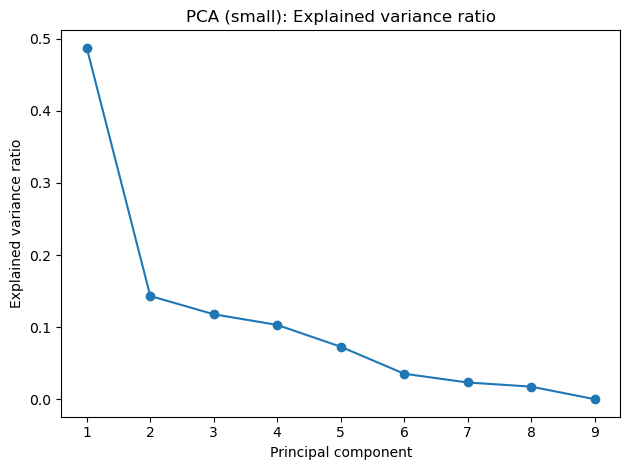

(                            PC1       PC2       PC3       PC4
 physicians_per_1000    0.423125 -0.081797 -0.187693 -0.109584
 life_expectancy        0.418826 -0.178764 -0.034412  0.055937
 pop_older65            0.410603 -0.140227 -0.130532 -0.165684
 gdp_per_capita         0.402772 -0.086444 -0.077534 -0.086261
 urban_pop              0.388989  0.372555  0.194986  0.157638
 pop_density            0.045499 -0.434075  0.494230  0.705282
 pop                    0.013264 -0.023158  0.785273 -0.598145
 pop_lower_half_median -0.099298  0.683860  0.059839  0.212298
 rural_pop             -0.388989 -0.372555 -0.194986 -0.157638,
                             PC1       PC2       PC3       PC4
 rural_pop             -0.388989 -0.372555 -0.194986 -0.157638
 pop_lower_half_median -0.099298  0.683860  0.059839  0.212298
 pop                    0.013264 -0.023158  0.785273 -0.598145
 pop_density            0.045499 -0.434075  0.494230  0.705282
 urban_pop              0.388989  0.372555  0.194986  

In [15]:
#Label wdi pca small

X_small = wdi_noNA_small[WDI_NUM_COLS].to_numpy() #it converts to numpy array
X_small = StandardScaler().fit_transform(X_small) #it standardizes the data

pca_small = PCA()
Z_small = pca_small.fit_transform(X_small)

# Plot for variance

plt.figure()
plt.plot(np.arange(1, len(pca_small.explained_variance_ratio_) + 1),
pca_small.explained_variance_ratio_, marker="o")
plt.title("PCA (small): Explained variance ratio")
plt.xlabel("Principal component")
plt.ylabel("Explained variance ratio")
plt.tight_layout()
plt.show()

# Loadings for first 4 PCs

loadings_small = pd.DataFrame(
pca_small.components_.T[:, :4],
index=WDI_NUM_COLS,
columns=["PC1", "PC2", "PC3", "PC4"]
)

loadings_small.sort_values("PC1", ascending=False).head(10), loadings_small.sort_values("PC1").head(10)


-In the small dataset, the PCA mainly describes development and health.

-Countries with high PCA values usually have, higher life expectancy, more doctors, higher income.

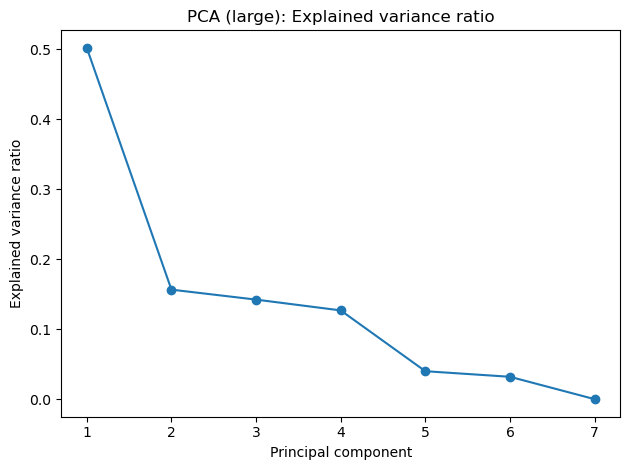

(                          PC1       PC2       PC3       PC4
 life_expectancy      0.455202 -0.133322  0.053256  0.273784
 urban_pop            0.453243  0.313037  0.007749 -0.436043
 physicians_per_1000  0.430516 -0.369391 -0.117948  0.122550
 pop_older65          0.425192 -0.358405 -0.004124  0.321872
 pop_density          0.123059  0.654264  0.364937  0.609890
 pop                 -0.025646 -0.305410  0.921920 -0.232789
 rural_pop           -0.453243 -0.313037 -0.007749  0.436043,
                           PC1       PC2       PC3       PC4
 rural_pop           -0.453243 -0.313037 -0.007749  0.436043
 pop                 -0.025646 -0.305410  0.921920 -0.232789
 pop_density          0.123059  0.654264  0.364937  0.609890
 pop_older65          0.425192 -0.358405 -0.004124  0.321872
 physicians_per_1000  0.430516 -0.369391 -0.117948  0.122550
 urban_pop            0.453243  0.313037  0.007749 -0.436043
 life_expectancy      0.455202 -0.133322  0.053256  0.273784)

In [16]:
#PCA large

X_large = wdi_noNA_large[WDI_NUM_COLS_LARGE].to_numpy()
X_large = StandardScaler().fit_transform(X_large)

pca_large = PCA()
Z_large = pca_large.fit_transform(X_large)

# Explained variance

plt.figure()
plt.plot(np.arange(1, len(pca_large.explained_variance_ratio_) + 1),
pca_large.explained_variance_ratio_, marker="o")
plt.title("PCA (large): Explained variance ratio")
plt.xlabel("Principal component")
plt.ylabel("Explained variance ratio")
plt.tight_layout()
plt.show()

# Loadings for first 4 PCs

loadings_large = pd.DataFrame(
pca_large.components_.T[:, :4],
index=WDI_NUM_COLS_LARGE,
columns=["PC1", "PC2", "PC3", "PC4"]
)

loadings_large.sort_values("PC1", ascending=False).head(10), loadings_large.sort_values("PC1").head(10)


In the large dataset, more countries are included.

-The plotter still represents development and health.

-This result is stable even when we change the dataset.